In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df=pd.read_csv("term-deposit-marketing-2020 - term-deposit-marketing-2020.csv")

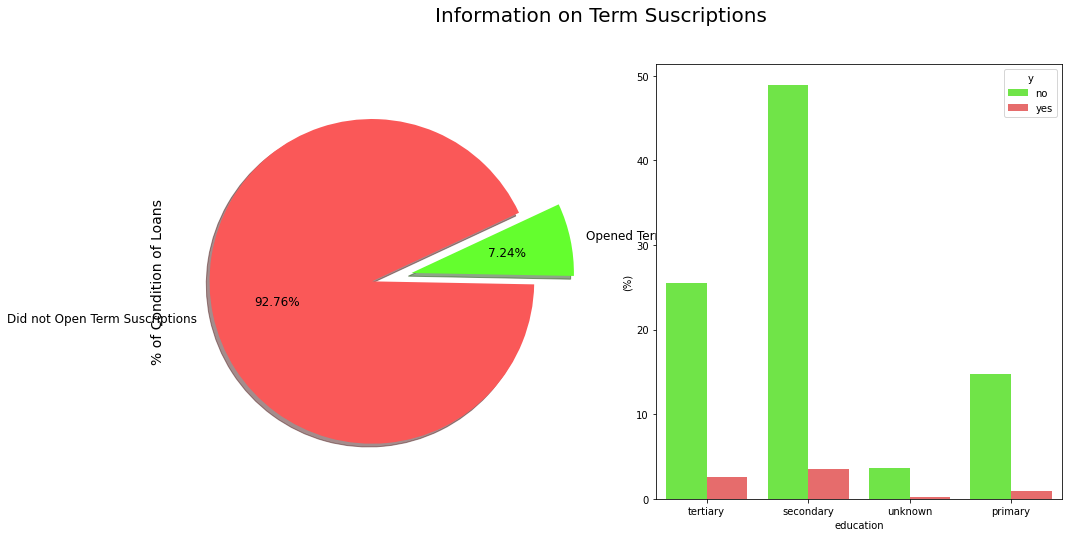

In [47]:
import seaborn as sns

f, ax = plt.subplots(1,2, figsize=(16,8))

colors = ["#FA5858", "#64FE2E"]
labels ="Did not Open Term Suscriptions", "Opened Term Suscriptions"

plt.suptitle('Information on Term Suscriptions', fontsize=20)

df["y"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=25)


# ax[0].set_title('State of Loan', fontsize=16)
ax[0].set_ylabel('% of Condition of Loans', fontsize=14)

# sns.countplot('loan_condition', data=df, ax=ax[1], palette=colors)
# ax[1].set_title('Condition of Loans', fontsize=20)
# ax[1].set_xticklabels(['Good', 'Bad'], rotation='horizontal')
palette = ["#64FE2E", "#FA5858"]

sns.barplot(x="education", y="balance", hue="y", data=df, palette=palette, estimator=lambda x: len(x) / len(df) * 100)
ax[1].set(ylabel="(%)")
ax[1].set_xticklabels(df["education"].unique(), rotation=0, rotation_mode="anchor")
plt.show()

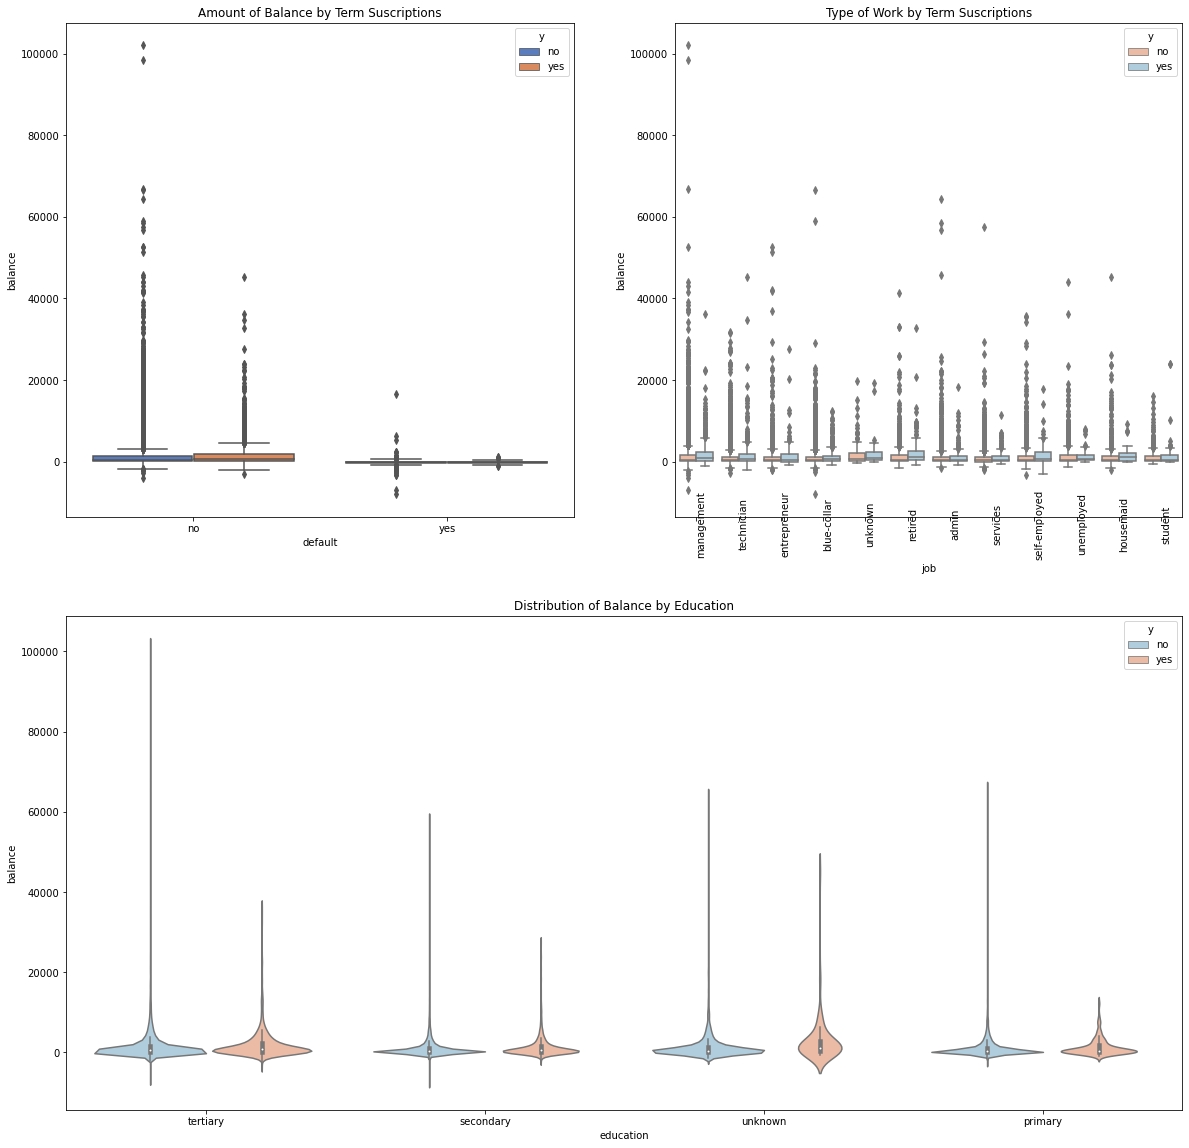

In [48]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

g = sns.boxplot(x="default", y="balance", hue="y",
                    data=df, palette="muted", ax=ax1)

g.set_title("Amount of Balance by Term Suscriptions")

# ax.set_xticklabels(df["default"].unique(), rotation=45, rotation_mode="anchor")

g1 = sns.boxplot(x="job", y="balance", hue="y",
                 data=df, palette="RdBu", ax=ax2)

g1.set_xticklabels(df["job"].unique(), rotation=90, rotation_mode="anchor")
g1.set_title("Type of Work by Term Suscriptions")

g2 = sns.violinplot(data=df, x="education", y="balance", hue="y", palette="RdBu_r")

g2.set_title("Distribution of Balance by Education")


plt.show()

In [49]:
# df=pd.read_csv("term-deposit-marketerm-deposit-marketing-2020.csv.csv")

df["OUTPUT_LABEL"] = (df.y == "yes").astype("int")

random_state = 30

In [50]:
numerical_cols = ["age", "balance", "day", "duration", "campaign"]
categorical_cols = ["job", "marital", "education", "default", "housing", "loan", "contact", "month"]


one_hot_cols = pd.get_dummies(df[categorical_cols], drop_first=False)
one_hot_cols.head()

df = pd.concat([df, one_hot_cols], axis=1)
one_hot_all = list(one_hot_cols.columns)

In [51]:
cols_input = numerical_cols + one_hot_all

data = df[cols_input + ["OUTPUT_LABEL"]]

In [52]:
data = data.sample(n=len(data), random_state=random_state)
data = data.reset_index(drop=True)

In [53]:
valid_test = data.sample(frac=0.30, random_state=random_state)

df_test = valid_test.sample(frac = 0.5, random_state=random_state)
df_valid = valid_test.drop(df_test.index)
df_train = data.drop(valid_test.index)

df_train_all = df_train.copy()

In [54]:
train_positive = df_train.OUTPUT_LABEL == 1
df_train_pos = df_train.loc[train_positive]
df_train_neg = df_train.loc[~train_positive]

df_train = pd.concat([df_train_pos, df_train_neg.sample(n=len(df_train_pos), random_state=random_state)], axis = 0)

df_train = df_train.sample(n=len(df_train), random_state=random_state).reset_index(drop=True)

In [55]:
val_positive = df_valid.OUTPUT_LABEL == 1
df_valid_pos = df_valid.loc[val_positive]
df_valid_neg = df_valid.loc[~val_positive]

df_valid = pd.concat([df_valid_pos, df_valid_neg.sample(n=len(df_valid_pos), random_state=random_state)], axis = 0)

df_valid = df_valid.sample(n=len(df_valid), random_state=random_state).reset_index(drop=True)

In [56]:
test_positive = df_test.OUTPUT_LABEL == 1
df_test_pos = df_test.loc[test_positive]
df_test_neg = df_test.loc[~test_positive]

df_test = pd.concat([df_test_pos, df_test_neg.sample(n=len(df_test_pos), random_state=random_state)], axis = 0)

df_test = df_test.sample(n=len(df_test), random_state=42).reset_index(drop=True)

In [57]:
X_train = df_train[cols_input].values
X_train_all = df_train_all[cols_input].values
X_valid = df_valid[cols_input].values
X_test = df_test[cols_input].values


y_train = df_train["OUTPUT_LABEL"].values
y_valid = df_valid["OUTPUT_LABEL"].values
y_test = df_test["OUTPUT_LABEL"].values

In [58]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train_all)

MinMaxScaler()

In [59]:
import pickle

scalerfile = "scaler.sav"
pickle.dump(scaler, open(scalerfile, "wb"))

scaler = pickle.load(open(scalerfile, "rb"))

In [60]:
X_train_minmax = scaler.transform(X_train)
X_valid_minmax = scaler.transform(X_valid)
X_test_minmax = scaler.transform(X_test)

In [61]:
from sklearn.svm import SVC
model_svc=SVC(kernel="rbf")
model_svc.fit(X_train_minmax, y_train)


y_train_pred = model_svc.predict(X_train_minmax)
y_valid_pred = model_svc.predict(X_valid_minmax)

In [62]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
cv = KFold(n_splits=5, random_state=1, shuffle=True)
scores = cross_val_score(model_svc, X_train_minmax, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: (%.3f) (%.3f)' % (scores.mean(), scores.std()))

Accuracy: (0.807) (0.013)


In [63]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = range(200,1000,200)
max_features = ["auto", "sqrt"]
max_depth = range(2,20,2)
min_samples_split = range(2,10,2)
criterion = ["gini", "entropy"]

random_grid = {"n_estimators":n_estimators,
              "max_features":max_features,
              "max_depth":max_depth,
              "min_samples_split":min_samples_split,
              "criterion":criterion}

In [64]:
from sklearn.metrics import make_scorer, roc_auc_score

auc_scoring = make_scorer(roc_auc_score)


from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter=200, cv=2, scoring=auc_scoring, verbose=1, random_state=random_state)

rf_random.fit(X_train_minmax, y_train)

Fitting 2 folds for each of 200 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  7.5min finished


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(), n_iter=200,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(2, 20, 2),
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': range(2, 10, 2),
                                        'n_estimators': range(200, 1000, 200)},
                   random_state=30, scoring=make_scorer(roc_auc_score),
                   verbose=1)

In [65]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 8,
 'max_features': 'sqrt',
 'max_depth': 16,
 'criterion': 'entropy'}

In [66]:
rf=RandomForestClassifier(max_depth=16, n_estimators=200, min_samples_split=8, criterion="entropy", max_features="sqrt",
                         random_state=random_state)
rf.fit(X_train_minmax, y_train)

y_train_pred = rf.predict_proba(X_train_minmax)[:, 1]
y_valid_pred = rf.predict_proba(X_valid_minmax)[:, 1]

In [67]:
rf_train_base_auc = roc_auc_score(y_train, y_train_pred)
rf_valid_base_auc = roc_auc_score(y_valid, y_valid_pred)

In [68]:
print("train auc:", rf_train_base_auc)
print("valid auc:", rf_valid_base_auc)

train auc: 0.9927960929435131
valid auc: 0.9457304526748971


In [69]:
cv = KFold(n_splits=5, random_state=1, shuffle=True)
scores = cross_val_score(rf, X_train_minmax, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: (%.3f) (%.3f)' % (scores.mean(), scores.std()))

Accuracy: (0.881) (0.007)


In [70]:
y_train_pred = rf.predict(X_train_minmax)
y_valid_pred = rf.predict(X_valid_minmax)
y_test_pred = rf.predict(X_test_minmax)

cv = KFold(n_splits=5, random_state=1, shuffle=True)
scores = cross_val_score(rf, X_test_minmax, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: (%.3f) (%.3f)' % (scores.mean(), scores.std()))

Accuracy: (0.873) (0.022)


Özellik Önem Sıralaması
1. özellik 3 (0.493884)
2. özellik 2 (0.058932)
3. özellik 0 (0.056736)
4. özellik 1 (0.053237)
5. özellik 4 (0.028665)
6. özellik 40 (0.025998)
7. özellik 33 (0.024994)
8. özellik 32 (0.020996)
9. özellik 30 (0.015856)
10. özellik 38 (0.013349)
11. özellik 26 (0.011879)
12. özellik 27 (0.011418)
13. özellik 43 (0.011166)
14. özellik 36 (0.011111)
15. özellik 34 (0.011019)
16. özellik 41 (0.010461)
17. özellik 42 (0.009561)
18. özellik 18 (0.008154)
19. özellik 39 (0.008078)
20. özellik 22 (0.007613)
21. özellik 6 (0.007591)
22. özellik 21 (0.006578)
23. özellik 14 (0.006518)
24. özellik 29 (0.006514)
25. özellik 19 (0.006500)
26. özellik 28 (0.006191)
27. özellik 5 (0.006160)
28. özellik 20 (0.006040)
29. özellik 9 (0.005930)
30. özellik 31 (0.005437)
31. özellik 37 (0.005244)
32. özellik 17 (0.005015)
33. özellik 12 (0.004453)
34. özellik 11 (0.004111)
35. özellik 10 (0.004006)
36. özellik 8 (0.003534)
37. özellik 7 (0.003529)
38. özellik 15 (0.003489)
39. öze

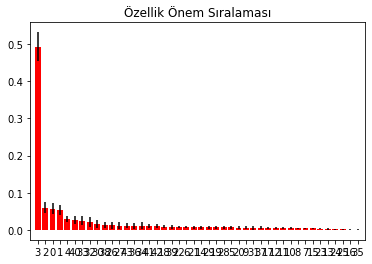

In [71]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Özellik Önem Sıralaması")

for f in range(X_train_minmax.shape[1]):
    print("%d. özellik %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.figure()
plt.title("Özellik Önem Sıralaması")
plt.bar(range(X_train_minmax.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_minmax.shape[1]), indices)
plt.xlim([-1, X_train_minmax.shape[1]])
plt.show()

In [45]:
data

,age,balance,day,duration,campaign,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,OUTPUT_LABEL
0,58,2143,5,261,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,44,29,5,151,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,33,2,5,76,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,47,1506,5,92,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,33,1,5,198,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,395,3,107,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
39996,30,3340,3,238,3,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
39997,54,200,3,170,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
39998,34,1047,3,342,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


Müşterinin son temas süresi vadeli mevduata abone olup olmamasını en fazla etkileyen değişkendir. Son temas Süresi arttıkça müşterinin vadeli mevduata abone olma olasılığı da artmaktadır. Daha sonra son temas günü, yaş ve yıllık ortalama bakiye miktarları vadeli mevduata abone olma durumunu etkileyen değişkenlerdir. Yine bu değişkenlerle abone olma durumu doğru orantılıdır. Yaş, son temas günü ve yıllık ortalama bakiye arttıkça abone olma olasılığı da artmaktadır. Ancak esas odaklanılması gereken değişken neredeyse tahmin modelininin yarısını açıklayan son temas süresidir.